# Assignment 2: Self-Driving Car -- Steering Angle Prediction
### Introduction to Deep Learning & GenAI

In this assignment we re-create Nvidia's end-to-end deep learning approach for mapping raw pixels using images captured from front-facing cameras mounted on a car. Each image has a corresponding steering angle associated with it that tells the position of the car's steering for that frame.

In this assignment, you will tackle this challenge using some deep learning models. You will:
- Train a convolutional neural network using Keras
- Explore model architectures
- Balance between model size and performance
- Implement fine-tuning from a pre-trained model

The datasets are large! Please download them from here: https://drive.google.com/drive/folders/1A1OMeS86E86rZ4ViMlvNPcKsb95kaOgM?usp=sharing

In [6]:
# Setup
import time
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

print("TensorFlow:", tf.__version__)
tf.random.set_seed(7)
np.random.seed(7)


TensorFlow: 2.20.0


## 1. Load the data

Load the datasets. We will work with input images `X` and continuous labels `y` (steering angle in radians, typically between about -0.5 and +0.5).

Print their shapes.


In [2]:
############## YOUR CODE HERE ##############
# Please update these lines to match where you saved the data!
#
X = np.load('data/NVIDIA_X.npy')
y = np.load('data/NVIDIA_Y.npy')
#
############## YOUR CODE HERE ##############


# Train/val/test split
n = len(X)
idx = np.random.permutation(n)
train_end = int(0.9*n)

train_idx, test_idx = idx[:train_end], idx[train_end:]
X_train, y_train = X[train_idx], y[train_idx]
X_test, y_test   = X[test_idx], y[test_idx]

print("Train:", X_train.shape, y_train.shape)
print("Test: ", X_test.shape, y_test.shape)


Train: (1159, 66, 200, 3) (1159,)
Test:  (129, 66, 200, 3) (129,)


Let's visualise some samples from our dataset.

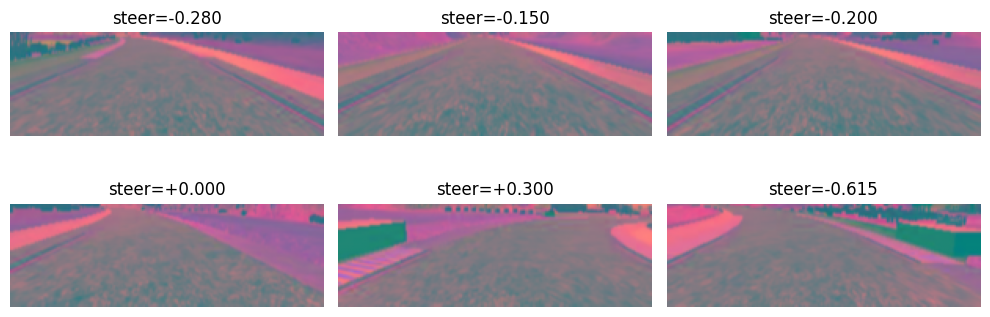

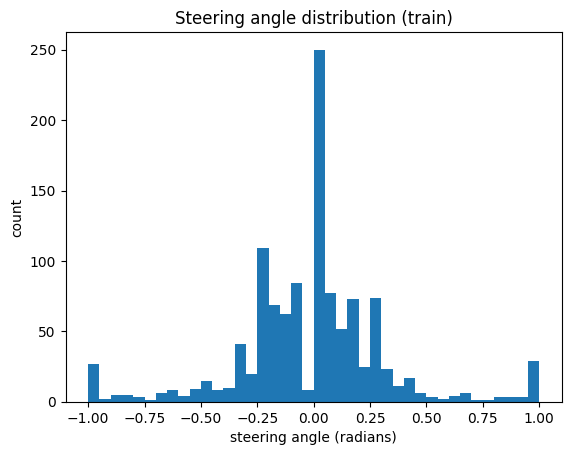

In [10]:
# Visualize a few samples
plt.figure(figsize=(10,4))
for i in range(6):
    ax = plt.subplot(2,3,i+1)
    j = np.random.randint(0, len(X_train))
    ax.imshow(X_train[j])
    ax.set_title(f"steer={y_train[j]:+.3f}")
    ax.axis("off")
plt.tight_layout()
plt.show()

# Label distribution
plt.figure()
plt.hist(y_train, bins=40)
plt.title("Steering angle distribution (train)")
plt.xlabel("steering angle (radians)")
plt.ylabel("count")
plt.show()


## 2. Baseline Model: Convolutional Neural Network

PilotNet (NVIDIA, 2016) popularized using a CNN for end-to-end steering prediction.
We’ll implement a **PilotNet-inspired** architecture (not necessarily identical).



In [11]:
# Implement RMSE as a performance metric
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

def build_pilotnet_model(input_shape=(66,200,3), dropout=0.0):
    '''
    PilotNet-inspired CNN for regression.
    width_mult scales channels and dense widths to create smaller/larger models.
    '''
    inputs = keras.Input(shape=input_shape)
    x = layers.Rescaling(1.0)(inputs)

    #Let's include 5 convolutional layers
    x = layers.Conv2D(24, 5, strides=2, activation="relu")(x)
    x = layers.Conv2D(36, 5, strides=2, activation="relu")(x)
    x = layers.Conv2D(48, 5, strides=2, activation="relu")(x)
    x = layers.Conv2D(64, 3, activation="relu")(x)
    x = layers.Conv2D(64, 3, activation="relu")(x)

    #Let's build a fully connected head
    x = layers.Flatten()(x)
    if dropout > 0:
        x = layers.Dropout(dropout)(x)
    x = layers.Dense(int(100), activation="relu")(x)
    x = layers.Dense(int(50), activation="relu")(x)
    x = layers.Dense(int(10), activation="relu")(x)
    outputs = layers.Dense(1)(x)

    return keras.Model(inputs, outputs, name=f"baseline_pilotnet")

baseline = build_pilotnet_model(dropout=0.1)
baseline.summary()


Model: "baseline_pilotnet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 66, 200, 3)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 66, 200, 3)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 31, 98, 24)     │         1,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 47, 36)     │        21,636 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 5, 22, 48)      │        43,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 3, 20, 64)      │        27,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 1, 18, 64)      │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │       115,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 252,219 (985.23 KB)

 Trainable params: 252,219 (985.23 KB)

 Non-trainable params: 0 (0.00 B)

Compile and train the above model:

In [12]:
baseline.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="mse",
    metrics=[keras.metrics.MeanAbsoluteError(name="mae"), rmse]
)

history = baseline.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=128,
    verbose=1
)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - loss: 0.1119 - mae: 0.2274 - rmse: 0.3345 - val_loss: 0.1341 - val_mae: 0.2519 - val_rmse: 0.2999
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - loss: 0.1100 - mae: 0.2254 - rmse: 0.3332 - val_loss: 0.1392 - val_mae: 0.2716 - val_rmse: 0.3916
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - loss: 0.1034 - mae: 0.2161 - rmse: 0.3415 - val_loss: 0.1152 - val_mae: 0.2377 - val_rmse: 0.3157
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - loss: 0.1094 - mae: 0.2377 - rmse: 0.3781 - val_loss: 0.1354 - val_mae: 0.2523 - val_rmse: 0.2892
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - loss: 0.1115 - mae: 0.2291 - rmse: 0.3335 - val_loss: 0.1344 - val_mae: 0.2521 - val_rmse: 0.3002
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - loss: 0.1119 - mae: 0.2298 - rmse: 0.3343 - val_loss: 0.1343 - val_mae: 0.2518 - val_rmse: 0.2957
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - loss: 0.1109 - mae: 0.2275 - rmse:

Let's evaluate the baseline on the test dataset:

Baseline test MAE:  0.2173
Baseline test RMSE: 0.3372


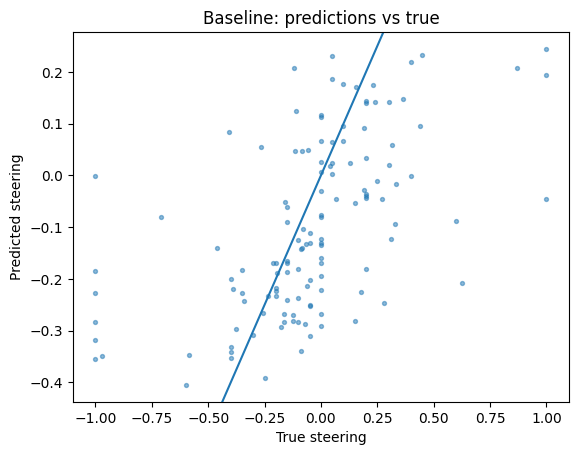

In [14]:
# Evaluate baseline
test_loss, test_mae, test_rmse = baseline.evaluate(X_test, y_test, verbose=0)
print(f"Baseline test MAE:  {test_mae:.4f}")
print(f"Baseline test RMSE: {test_rmse:.4f}")

y_pred = baseline.predict(X_test, verbose=0).squeeze()

plt.figure()
plt.scatter(y_test, y_pred, s=8, alpha=0.5)
plt.xlabel("True steering")
plt.ylabel("Predicted steering")
plt.title("Baseline: predictions vs true")
plt.axline((0,0), slope=1)
plt.show()

The baseline model shows a positive correlation between the predicted and true steering angles, with most predictions concentrated around steering values between −0.35 and 0.3, where the data density is highest. However, the model struggles to accurately predict larger steering angles, partly due to the scarcity of extreme samples in the dataset. As the true steering angle increases in magnitude, the model tends not to follow these extreme values and instead pulls predictions toward zero. For example, when the true steering angle is around ±0.8, the predicted values are often closer to ±0.3 or nearer to zero. This behavior reflects regression to the mean, where the model favors predicting the most common steering angles observed in the training data. As a result, larger prediction errors occur at the tails of the steering angle distribution.

While the MAE represents the average absolute error, the RMSE penalizes large errors more heavily because errors are squared before averaging and then square-rooted. As a result, the presence of a few large errors—particularly for extreme steering angles—causes the RMSE to be substantially larger than the MAE. Overall, the baseline model underfits the data and serves primarily as a reference point for more complex models.

## 3. Efficiency: accuracy vs parameters vs speed

In deployment, you might care about:
- *Parameter count* (memory footprint)
- *Model size*
- *Inference speed / latency*
- Accuracy (MAE/RMSE)

Build at least 3 models that trade off accuracy vs efficiency. **You will need to extend this notebook with more coding  cells and/or a for loop to try different models!** 
Suggested knobs:
- Width/depth of the network
- Sizes of the convolutional layers
- Trying new layer types in Keras, e.g., *GlobalAveragePooling*

Create a small “leaderboard” table of:
- test MAE, test RMSE
- parameter count
- estimated model size (MB)
- inference time (ms per batch)

Plot a Pareto-style scatter plot: MAE vs parameter count. Please help complete the below helper functions.
**Do not** change any existing lines, only fill in the sections marked: 
```
############## YOUR CODE HERE ##############
#                                           
#                                           
############## YOUR CODE HERE ##############


In [15]:
import pandas as pd

def count_params(model):
    # Count the number of trainable parameters in the model
    ############## YOUR CODE HERE ##############
    #
    num_trainable_params = model.count_params()
    #
    ############## YOUR CODE HERE ##############
    return num_trainable_params

def estimate_model_size_mb(model):
    # Rough estimate: float32 weights = 4 bytes each (ignores optimizer state)
    return count_params(model) * 4 / (1024**2)

@tf.function
def _predict_graph(model, x):
    return model(x, training=False)

def benchmark_inference_ms(model, batch=64, iters=30, warmup=10):
    x = tf.convert_to_tensor(X_test[:batch])
    for _ in range(warmup):
        _ = _predict_graph(model, x)
    t0 = time.time()
    for _ in range(iters):
        _ = _predict_graph(model, x)
    t1 = time.time()
    return (t1 - t0) * 1000 / iters


Let's evaluate using our performance metrics:

In [16]:
# Evaluate results for baseline model

baseline_params = count_params(baseline)
baseline_size_mb = estimate_model_size_mb(baseline)
baseline_inference_ms = benchmark_inference_ms(baseline, batch=64)

print(f"Baseline model parameters: {baseline_params:,}")
print(f"Baseline model size: {baseline_size_mb:.2f} MB")
print(f"Baseline model inference time (64 batch): {baseline_inference_ms:.2f} ms")

Baseline model parameters: 252,219
Baseline model size: 0.96 MB
Baseline model inference time (64 batch): 18.74 ms


In [17]:
model_configs = {
    "small": {
        "conv_filters": [16, 32],
        "use_gap": True,
        "dense_units": []
    },
    "medium": {
        "conv_filters": [24, 36, 48],
        "use_gap": False,
        "dense_units": [100]
    },
    "large": {
        "conv_filters": [32, 64, 128, 128],
        "use_gap": False,
        "dense_units": [200, 50]
    }
}

def build_model(config):
    model = models.Sequential()

    # Input layer
    model.add(layers.Input(shape=X_train.shape[1:]))

    # Convolutional layers
    for filters in config["conv_filters"]:
        model.add(layers.Conv2D(filters, (3, 3), activation='relu'))
        model.add(layers.MaxPooling2D((2, 2)))

    # Feature aggregation
    if config["use_gap"]:
        model.add(layers.GlobalAveragePooling2D())
    else:
        model.add(layers.Flatten())

    # Fully connected layers
    for units in config["dense_units"]:
        model.add(layers.Dense(units, activation='relu'))

    # Output layer (regression)
    model.add(layers.Dense(1))

    # Compile model
    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mae']
    )

    return model
results = []

EPOCHS = 5       
BATCH_SIZE = 64

for name, config in model_configs.items():
    print(f"\nTraining model: {name}")

    # Build model
    model = build_model(config)

    # Train model
    history = model.fit(
        X_train, y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=0.1,
        verbose=0
    )

    # Evaluate on test set
    test_loss, test_mae = model.evaluate(
        X_test, y_test,
        batch_size=BATCH_SIZE,
        verbose=0
    )

    # Compute RMSE from MSE loss
    test_rmse = np.sqrt(test_loss)

    # Efficiency metrics
    params = count_params(model)
    size_mb = estimate_model_size_mb(model)
    inference_ms = benchmark_inference_ms(model, batch=BATCH_SIZE)

    # Store results
    results.append({
        "Model": name,
        "Test MAE": test_mae,
        "Test RMSE": test_rmse,
        "Params": params,
        "Model Size (MB)": size_mb,
        "Inference Time (ms)": inference_ms
    })

    print(f"{name}: MAE={test_mae:.4f}, RMSE={test_rmse:.4f}, "
          f"Params={params:,}, Size={size_mb:.2f}MB, "
          f"Inference={inference_ms:.2f}ms")


Training model: small
small: MAE=0.2541, RMSE=0.3687, Params=5,121, Size=0.02MB, Inference=22.51ms

Training model: medium
medium: MAE=0.1717, RMSE=0.2265, Params=686,685, Size=2.62MB, Inference=41.62ms

Training model: large
large: MAE=0.1637, RMSE=0.2117, Params=763,133, Size=2.91MB, Inference=77.45ms


In [18]:
df_results = pd.DataFrame(results)
df_results


,Model,Test MAE,Test RMSE,Params,Model Size (MB),Inference Time (ms)
0,small,0.254055,0.368745,5121,0.019535,22.508033
1,medium,0.171696,0.226465,686685,2.619495,41.622432
2,large,0.163695,0.211665,763133,2.911121,77.445666


The results in the leaderboard demonstrate a clear trade-off between accuracy and efficiency. The small model is extremely lightweight, with only 5,121 parameters and a model size of approximately 0.02 MB, making it the most memory-efficient option. However, this efficiency comes at the cost of accuracy, as it exhibits the highest MAE and RMSE among the three models.

The medium model achieves a substantial improvement in predictive performance, reducing MAE and RMSE significantly compared to the small model, while maintaining a moderate parameter count and inference time. This suggests that increasing network width and depth provides meaningful gains in accuracy without an excessive increase in computational cost.

The large model delivers the best accuracy, achieving the lowest MAE and RMSE. However, these improvements are marginal relative to the medium model, while the parameter count and inference time increase considerably. This indicates diminishing returns in accuracy as model complexity grows.

Overall, the medium model represents the best balance between accuracy and efficiency, whereas the small model is suitable for highly resource-constrained scenarios and the large model may be preferred when accuracy is the primary concern.

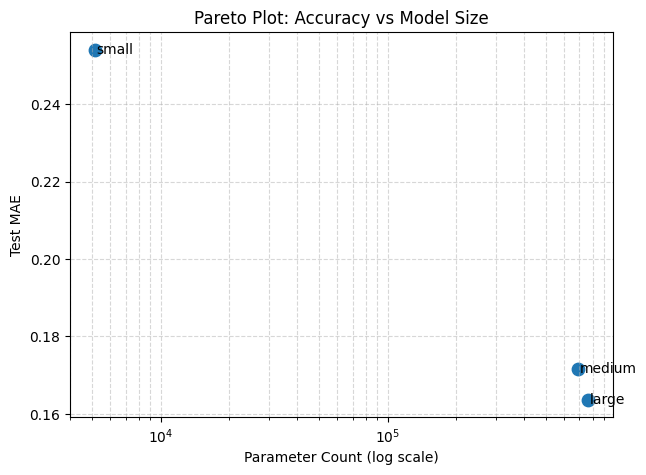

In [19]:
plt.figure(figsize=(7, 5))

plt.scatter(
    df_results["Params"],
    df_results["Test MAE"],
    s=80
)

# Annotate each point with model name
for i, row in df_results.iterrows():
    plt.text(
        row["Params"] * 1.02,
        row["Test MAE"],
        row["Model"],
        fontsize=10,
        verticalalignment='center'
    )

plt.xscale("log")  
plt.xlabel("Parameter Count (log scale)")
plt.ylabel("Test MAE")
plt.title("Pareto Plot: Accuracy vs Model Size")

plt.grid(True, which="both", linestyle="--", alpha=0.5)
plt.show()


The Pareto plot illustrates the trade-off between model accuracy and efficiency. As parameter count increases, the test MAE generally decreases, indicating improved predictive performance at the cost of higher model complexity. The small model occupies the low-parameter, high-error region, while the large model achieves the lowest MAE with the highest parameter count. Notably, the medium model lies near the Pareto frontier, offering a strong balance between accuracy and efficiency, as it achieves a substantial reduction in MAE with a moderate increase in parameters. This suggests diminishing returns in accuracy when moving from the medium to the large model.

### 4. Transfer learning + fine-tuning

Many real-world problems benefit from **pretrained** large models (ImageNet) even when the final task is regression.

You will:
1. Use a pretrained backbone (e.g., MobileNetV2) as a feature extractor
2. Train a small regression head




In [20]:
def build_mobilenet_regressor(input_shape=(66,200,3)):
    inp = keras.Input(shape=input_shape)

    # MobileNetV2 expects inputs in [-1, 1]
    x = layers.Rescaling(2.0, offset=-1.0)(inp)

    backbone = keras.applications.MobileNetV2(
        include_top=False, weights="imagenet", input_tensor=x
    )
    backbone.trainable = False

    x = backbone.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(64, activation="relu")(x)
    out = layers.Dense(1)(x)
    return keras.Model(inp, out, name="mobilenetv2_regressor")

# Frozen lower layers
tl_frozen = build_mobilenet_regressor()
tl_frozen.compile(optimizer=keras.optimizers.Adam(1e-3), loss="mse",
                  metrics=[keras.metrics.MeanAbsoluteError(name="mae"), rmse])

tl_frozen.summary()

tl_frozen.fit(
    X_train, y_train, validation_data=(X_test, y_test),
    epochs=15, batch_size=64, verbose=1
)

print("Frozen backbone test:", tl_frozen.evaluate(X_test, y_test, verbose=0))


/var/folders/99/gjjr_09d14z890f5txh4xywm0000gn/T/ipykernel_9091/2397526369.py:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  backbone = keras.applications.MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "mobilenetv2_regressor"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 66, 200,   │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 66, 200,   │          0 │ input_layer_5[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 33, 100,   │        864 │ rescaling_1[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 33, 100,   │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 33, 100,   │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 33, 100,   │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 33, 100,   │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 33, 100,   │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 33, 100,   │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 33, 100,   │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 33, 100,   │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 33, 100,   │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 33, 100,   │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 35, 101,   │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 17, 50,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 17, 50,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 17, 50,    │          0 │ block_1_depthwis

 Total params: 2,340,033 (8.93 MB)

 Trainable params: 82,049 (320.50 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 267ms/step - loss: 1.7821 - mae: 1.0185 - rmse: 1.1220 - val_loss: 0.5555 - val_mae: 0.6557 - val_rmse: 0.5438
Epoch 2/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 221ms/step - loss: 0.2403 - mae: 0.3872 - rmse: 0.5132 - val_loss: 0.1306 - val_mae: 0.2822 - val_rmse: 0.4281
Epoch 3/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - loss: 0.1423 - mae: 0.2869 - rmse: 0.4323 - val_loss: 0.1057 - val_mae: 0.2445 - val_rmse: 0.4033
Epoch 4/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step - loss: 0.1107 - mae: 0.2559 - rmse: 0.4161 - val_loss: 0.1030 - val_mae: 0.2458 - val_rmse: 0.3905
Epoch 5/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - loss: 0.0925 - mae: 0.2341 - rmse: 0.4154 - val_loss: 0.0918 - val_mae: 0.2280 - val_rmse: 0.4105
Epoch 6/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - loss: 0.0815 - mae: 0.2210 - rmse: 0.4198 - val_loss: 0.0896 - val_mae: 0.2248 - val_rmse: 0.4087
Epoch 7/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - loss: 0.0731 - mae: 0.2098 - rmse:

Let's evaluate using our same performance metrics:

In [21]:
# Evaluate results for fine-tuned model

finetuning_params = count_params(tl_frozen)
finetuning_size_mb = estimate_model_size_mb(tl_frozen)
finetuning_inference_ms = benchmark_inference_ms(tl_frozen, batch=64)

print(f"Fine-tuned model parameters: {finetuning_params:,}")
print(f"Fine-tuned model size: {finetuning_size_mb:.2f} MB")
print(f"Fine-tuned model inference time (64 batch): {finetuning_inference_ms:.2f} ms")

Fine-tuned model parameters: 2,340,033
Fine-tuned model size: 8.93 MB
Fine-tuned model inference time (64 batch): 154.16 ms


The fine-tuned transfer learning model significantly increases the number of parameters and inference cost compared to the baseline and efficiency-oriented models. With over 2.3 million parameters and an estimated size of 8.93 MB, the model exhibits substantially higher memory footprint and latency (154 ms per batch), making it less suitable for real-time or resource-constrained deployment.

This increase in computational cost is expected, as fine-tuning allows the pretrained backbone to adapt low- and mid-level visual features to the steering prediction task. While this may improve prediction accuracy, it highlights a clear trade-off between accuracy and efficiency. In practice, such a model would be better suited for offline training or high-performance systems, whereas smaller or partially fine-tuned models offer a more balanced accuracy-efficiency trade-off.

## 7. Reflection

In 2-3 sentences each, please answer:
1. **Accuracy vs efficiency:** Which model(s) has the best tradeoff? Explain using your table/plot.
(**Note: marks are based on reflection, not on what accuracy you found!**)
2. **Deployment framing:** If you had to deploy on a low-power device (e.g., a dashboard camera), what would you choose and why?
3. **Where do parameters “live”?** In your baseline, which parts contribute most to parameter count (conv vs dense)? What architectural change reduced it most?
4. **Transfer learning:** Did the pretrained backbone help? Under what conditions do you think transfer learning is most useful?
5. **Ethics & risk (short):** What are possible risks of steering-angle prediction models? What mitigations would you propose?

In [ ]:
############## YOUR RESPONSE HERE ##############
#
# Question 1:
#Among the evaluated models, the medium model provides the best trade-off between accuracy and efficiency. It significantly improves MAE and RMSE compared to the small model, while keeping parameter count, model size, and inference time much lower than the large and fine-tuned models.
# Question 2:
#For deployment on a low-power device such as a dashboard camera, the small or medium model would be preferred. These models have substantially lower memory footprint and faster inference time, making them suitable for real-time operation under hardware constraints.
# Question 3:
#In the baseline model, the majority of parameters reside in the fully connected (dense) layers rather than the convolutional layers. Replacing dense layers with GlobalAveragePooling and reducing network width significantly reduced the overall parameter count.
# Question 4:
#The pretrained backbone improves performance by providing strong low-level and mid-level visual features, especially when training data is limited. However, this benefit comes at the cost of increased model size and inference time.
# Question 5:
#Steering-angle prediction models may fail in rare or unseen scenarios, potentially leading to unsafe driving behavior. Dataset bias, lack of interpretability, and over-reliance on automation also pose risks. Mitigations include extensive testing in edge cases, uncertainty-aware predictions, and keeping a human-in-the-loop for safety-critical decisions.
############## YOUR RESPONSE HERE ##############